In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [2]:
opened = pd.read_csv('email_opened_table.csv')
email = pd.read_csv('email_table.csv')
link_clicked = pd.read_csv('link_clicked_table.csv')

In [9]:
opened['opened_email'] = 1
df= email.merge(opened, how = 'left', on ='email_id')

In [10]:
link_clicked['clicked_link'] = 1
df= df.merge(link_clicked, how = 'left', on = 'email_id')

In [12]:
df.sample(10)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened_email,clicked_link
12414,257129,short_email,personalized,11,Monday,US,4,NaN,NaN
407,141458,short_email,personalized,11,Tuesday,US,5,NaN,NaN
82505,293115,short_email,personalized,10,Sunday,UK,8,NaN,NaN
19848,164091,long_email,personalized,5,Tuesday,ES,7,NaN,NaN
93983,816689,long_email,generic,8,Tuesday,ES,6,NaN,NaN
80744,734195,long_email,generic,7,Thursday,US,3,NaN,NaN
95624,699137,long_email,personalized,14,Saturday,US,4,NaN,NaN
94706,632533,short_email,personalized,3,Friday,UK,8,1.0,NaN
82052,985969,short_email,generic,8,Saturday,UK,0,NaN,NaN
62138,552800,long_email,generic,2,Wednesday,US,1,NaN,NaN


## Question 1: What percentage of users opened the email and what percentage clicked on the link within the email?

In [17]:
# the number of email _id
len(df)

100000

In [14]:
# the number of people opened the email
len(df[df['opened_email'] == 1])

10345

In [16]:
# the number of people clicked the link within the email
len(df[df['clicked_link'] ==1])

2119

In [19]:
print('The percentage of users opened the email is {:2.2%}'.format(len(df[df['opened_email'] == 1])/ len(df)))

The percentage of users opened the email is 10.35%


In [20]:
print('The percentage of users who clicked on the link within the email is {:2.2%}'.format(len(df[df['clicked_link'] ==1])/len(df)))

The percentage of users who clicked on the link within the email is 2.12%


## Question 2:  The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?

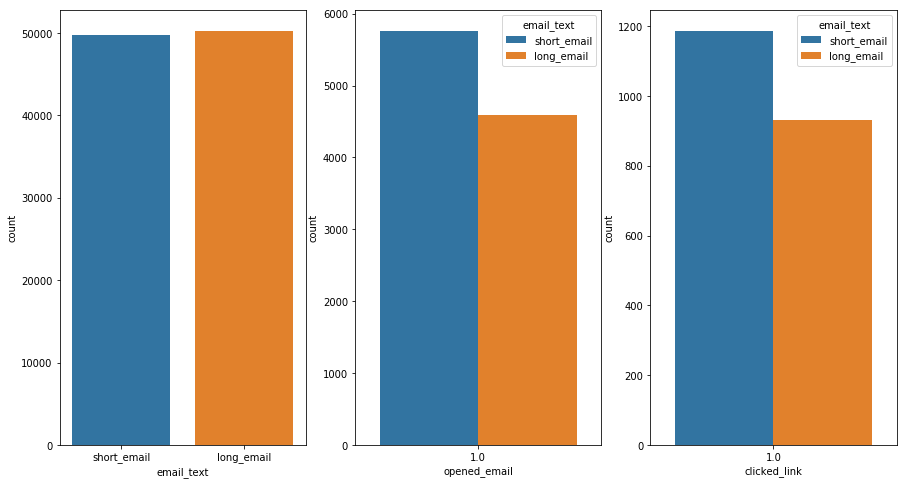

In [31]:
fig, ax = plt.subplots(1, 3, figsize = (15,8))

sns.countplot('email_text', data = df, ax= ax[0])

sns.countplot('opened_email', hue= 'email_text', data= df, ax= ax[1])

sns.countplot('clicked_link', hue = 'email_text', data= df, ax=ax[2] )

In [32]:
# Number of emails got opened and links got clicked are higher in the short emails. It's very reasonable

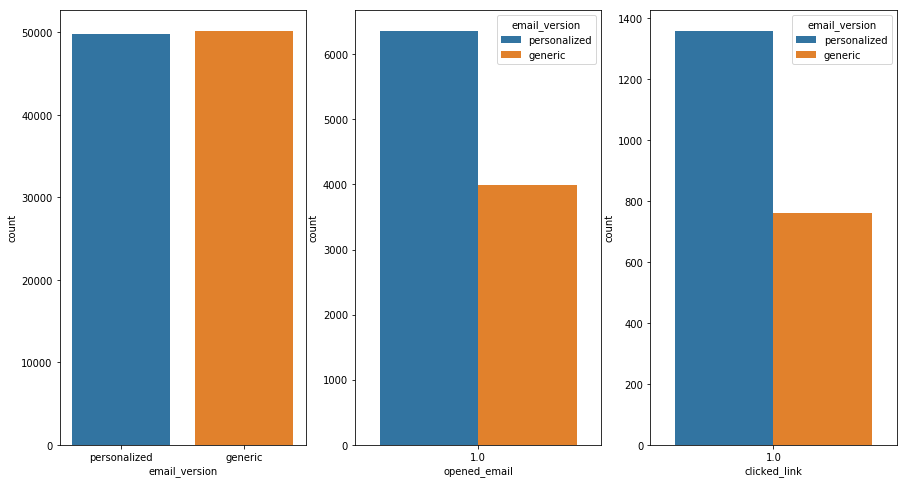

In [33]:
fig, ax = plt.subplots(1, 3, figsize = (15,8))

sns.countplot('email_version', data = df, ax= ax[0])

sns.countplot('opened_email', hue= 'email_version', data= df, ax= ax[1])

sns.countplot('clicked_link', hue = 'email_version', data= df, ax=ax[2] )

In [34]:
# Number of emails got opened and links got clicked are higher in the personalized email context.

In [71]:
grouped_cnt = df.groupby('weekday')['opened_email', 'clicked_link'].sum().reset_index()

In [72]:
tmp1= df.groupby('weekday')['email_id'].count().reset_index()

In [81]:
df2= grouped_cnt.merge(tmp1, how = 'left', on = 'weekday')
df2.rename({'email_id' : 'email_count'}, axis = 1, inplace = True)

In [83]:
df2['ctp'] = df2['clicked_link']/ df2['email_count']

In [94]:
df2['open_proba'] = df2['opened_email'] /df2['email_count']

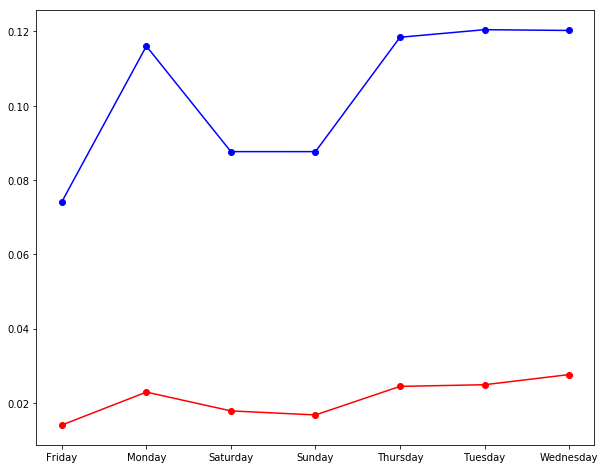

In [96]:
fig, ax = plt.subplots(figsize= (10,8))
plt.plot('weekday', 'ctp', data= df2, marker= 'o', color= 'red')
plt.plot('weekday', 'open_proba', data= df2, marker= 'o', color= 'blue')

In [98]:
# the probability of opening emails and clicking links is relatively higher from Monday to Thursday

In [99]:
country_group = df.groupby('user_country')['opened_email', 'clicked_link'].sum().reset_index()

In [100]:
country_group

,user_country,opened_email,clicked_link
0,ES,390.0,83.0
1,FR,406.0,80.0
2,UK,2396.0,492.0
3,US,7153.0,1464.0


In [111]:
tmp2 = df.groupby('user_country')['email_id'].count().reset_index()

In [115]:
country_group= country_group.merge(tmp2, how = 'left', on = 'user_country')
country_group.rename({'email_id' :'email_count'}, axis =1, inplace = True)

In [119]:
country_group['ctp'] = country_group['clicked_link'] /country_group['email_count']
country_group['open_prob']= country_group['opened_email'] / country_group['email_count']
country_group

,user_country,opened_email,clicked_link,email_count,ctp,open_prob
0,ES,390.0,83.0,9967,0.008327,0.039129
1,FR,406.0,80.0,9995,0.008004,0.040620
2,UK,2396.0,492.0,19939,0.024675,0.120167
3,US,7153.0,1464.0,60099,0.024360,0.119020


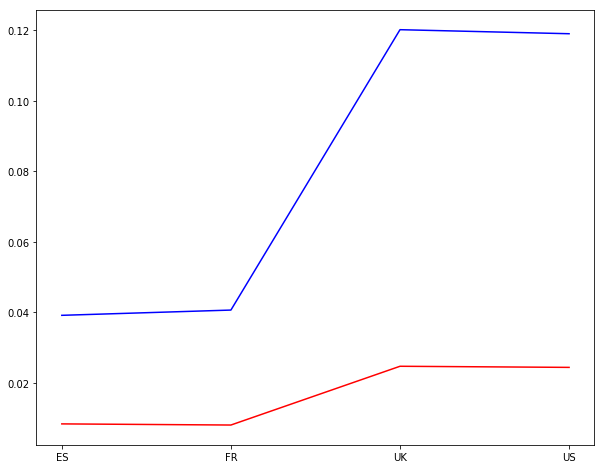

In [120]:
fig, ax = plt.subplots(figsize = (10,8))
plt.plot('user_country','open_prob', data= country_group, color = 'blue')
plt.plot('user_country', 'ctp', data= country_group, color= 'red')

In [129]:
purchase_group = df.groupby('user_past_purchases')['opened_email', 'clicked_link'].sum().reset_index()

In [130]:
tmp3 = df.groupby('user_past_purchases')['email_id'].count().reset_index()

In [131]:
purchase_group = purchase_group.merge(tmp3, how = 'left', on = 'user_past_purchases')
purchase_group.rename({'email_id' : 'email_count'}, axis =1, inplace= True)

In [132]:
purchase_group.head()

,user_past_purchases,opened_email,clicked_link,email_count
0,0,532.0,7.0,13877
1,1,1276.0,154.0,13751
2,2,1320.0,200.0,13036
3,3,1305.0,200.0,12077
4,4,1195.0,230.0,10743


In [133]:
purchase_group['ctp'] = purchase_group['clicked_link'] / purchase_group['email_count']
purchase_group['open_prob'] = purchase_group['opened_email'] / purchase_group['email_count']

In [135]:
purchase_group

,user_past_purchases,opened_email,clicked_link,email_count,ctp,open_prob
0,0,532.0,7.0,13877,0.000504,0.038337
1,1,1276.0,154.0,13751,0.011199,0.092793
2,2,1320.0,200.0,13036,0.015342,0.101258
3,3,1305.0,200.0,12077,0.016560,0.108057
4,4,1195.0,230.0,10743,0.021409,0.111235
5,5,1052.0,201.0,9042,0.022230,0.116346
6,6,928.0,241.0,7518,0.032056,0.123437
7,7,744.0,186.0,6051,0.030739,0.122955
8,8,613.0,174.0,4393,0.039608,0.139540
9,9,444.0,150.0,3296,0.045510,0.134709


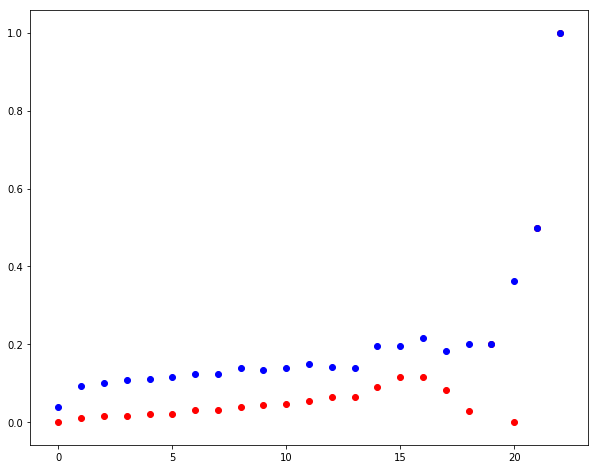

In [140]:
fig, ax = plt.subplots(figsize = (10,8))
plt.scatter('user_past_purchases', 'ctp', data = purchase_group, color= 'red')
plt.scatter('user_past_purchases', 'open_prob', data= purchase_group, color= 'blue')

In [141]:
# There is an obvious upward trending in the graph. It might be the reason that loyal customers are more likely to read and click links

In [153]:
b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
df['time'] = pd.cut(df['hour'], bins=b, labels=l, include_lowest=True)

In [155]:
## Some data cleaning before fitting a model
LB=LabelEncoder()
df['email_text'] = LB.fit_transform(df['email_text'])
df['email_version'] = LB.fit_transform(df['email_version'])
df['weekday'] = LB.fit_transform(df['weekday'])
df['user_country'] =  LB.fit_transform(df['user_country'])
df['time'] = LB.fit_transform(df['time'])
df= df.fillna(0)

In [161]:
X= df[['email_text', 'email_version', 'time', 'weekday', 'user_country', 'user_past_purchases']]
y= df['clicked_link']

In [164]:
x_train, x_test, y_train, y_test= train_test_split(X, y, test_size = 0.25)

In [165]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [166]:
pred= rf.predict(x_test)

In [168]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     24470
         1.0       0.06      0.01      0.01       530

   micro avg       0.98      0.98      0.98     25000
   macro avg       0.52      0.50      0.50     25000
weighted avg       0.96      0.98      0.97     25000



In [173]:
pred_proba = rf.predict_proba(x_test)
fpr1,tpr1,thresholds = roc_curve(y_test,1-pd.DataFrame(pred_proba).iloc[:,0])

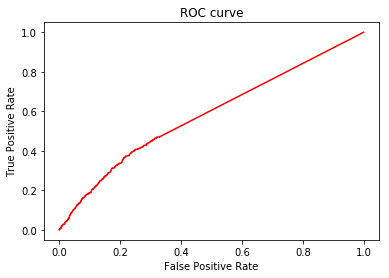

In [174]:
plt.plot(fpr1,tpr1, color = 'red')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

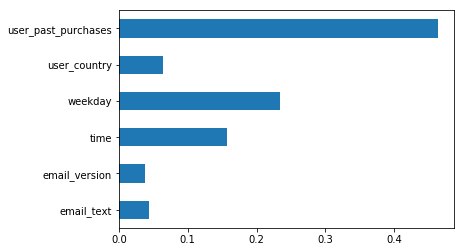

In [184]:
(pd.Series(rf.feature_importances_, index=X.columns)
   .plot(kind='barh'))

## Question 3: By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email). How would you test that?

Use A/B test to test the change after we got from Question 3.

## Question 4: Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

Please see above